<a href="https://colab.research.google.com/github/marcelo-custodio/federated_fraud_detection/blob/main/teste_ae_centralizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support, confusion_matrix, roc_curve, auc

# Reprodutibilidade básica
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


In [41]:
DATA_PATH = "creditcard.csv"
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
display(df.head())
display(df['Class'].value_counts())


Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


,count
Class,
0,284315
1,492


In [42]:
df = df.copy()
df = df.drop(columns=['Time'])

# Escalar Amount
scaler_amount = StandardScaler()
df['Amount_scaled'] = scaler_amount.fit_transform(df[['Amount']])
df = df.drop(columns=['Amount'])

cols = [c for c in df.columns if c != 'Class'] + ['Class']
df = df[cols]

# Separar X e y
X = df.drop(columns=['Class']).values
y = df['Class'].values

print("X shape:", X.shape)
print("Fraud ratio:", y.sum() / len(y))


X shape: (284807, 29)
Fraud ratio: 0.001727485630620034


In [43]:
X_norm = X[y == 0]
X_fraud = X[y == 1]
X_norm_train, X_norm_valtest = train_test_split(X_norm, test_size=0.2, random_state=SEED)

# Construir conjunto de teste: pegar X_norm_valtest + todas fraudes
X_test = np.vstack([X_norm_valtest, X_fraud])
y_test = np.hstack([np.zeros(len(X_norm_valtest), dtype=int), np.ones(len(X_fraud), dtype=int)])

# Também separar uma validação somente de normais para monitoramento (opcional)
X_val = X_norm_valtest  # já está só com normais

print("Train (somente normais):", X_norm_train.shape)
print("Val (normais):", X_val.shape)
print("Test (normais + fraudes):", X_test.shape, "   Frauds in test:", y_test.sum())


Train (somente normais): (227452, 29)
Val (normais): (56863, 29)
Test (normais + fraudes): (57355, 29)    Frauds in test: 492


In [64]:
input_dim = X.shape[1]
reg_l2 = 1e-4
dropout_rate = 0.2

inp = layers.Input(shape=(input_dim,))

# Encoder
x = layers.Dense(128, activation=None,
                 kernel_regularizer=regularizers.l2(reg_l2))(inp)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(dropout_rate)(x)

x = layers.Dense(64, activation=None,
                 kernel_regularizer=regularizers.l2(reg_l2))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(dropout_rate)(x)

latent = layers.Dense(16, activation=None,
                      kernel_regularizer=regularizers.l2(reg_l2),
                      name="latent_space")(x)
latent = layers.BatchNormalization()(latent)
latent = layers.ReLU()(latent)

# Decoder
x = layers.Dense(64, activation=None,
                 kernel_regularizer=regularizers.l2(reg_l2))(latent)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(dropout_rate)(x)

x = layers.Dense(128, activation=None,
                 kernel_regularizer=regularizers.l2(reg_l2))(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(dropout_rate)(x)

out = layers.Dense(input_dim, activation='linear')(x)

autoencoder = models.Model(inp, out, name='deep_autoencoder')
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    loss='mse')
autoencoder.summary()

Model: "deep_autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │         3,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ latent_space (Dense)            │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 29)             │         3,741 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,885 (108.93 KB)

 Trainable params: 27,085 (105.80 KB)

 Non-trainable params: 800 (3.12 KB)

In [65]:
EPOCHS = 100
BATCH = 1024

es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = autoencoder.fit(
    X_norm_train, X_norm_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    validation_data=(X_val, X_val),
    callbacks=[es]
)


Epoch 1/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 1.1044 - val_loss: 0.4669
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.5499 - val_loss: 0.3262
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.4576 - val_loss: 0.2755
Epoch 4/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.4109 - val_loss: 0.2440
Epoch 5/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 0.3784 - val_loss: 0.2198
Epoch 6/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.3562 - val_loss: 0.2004
Epoch 7/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - loss: 0.3396 - val_loss: 0.1869
Epoch 8/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.3267 - val_loss: 0.1793
Epoch 9/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3170 - val_loss: 0.1699
Epoch 10/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.3088 - val_loss: 0.1615
Epoch 11/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.2986 - val_loss: 0.1548
Epoch 12/100
223/223 ━━━━━━━

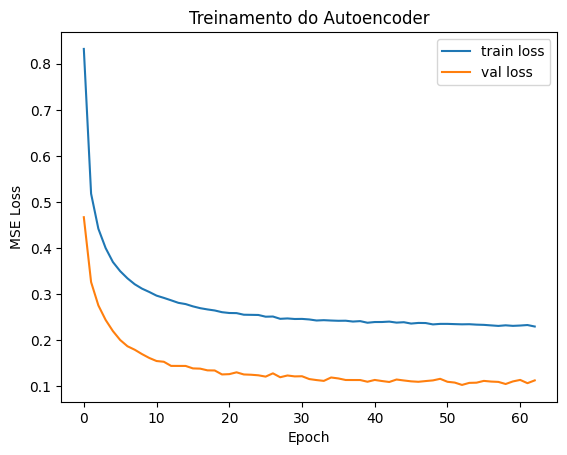

In [66]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Treinamento do Autoencoder')
plt.show()


1793/1793 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


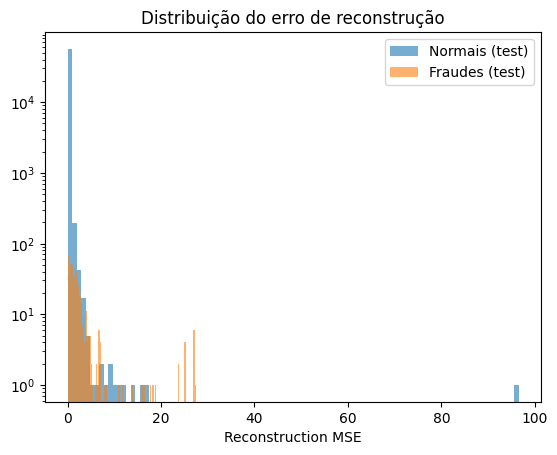

In [67]:
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.square(X_test - X_test_pred), axis=1)

# visualizar distribuições de MSE para normais x fraudes
mse_norm = mse[y_test == 0]
mse_fraud = mse[y_test == 1]

plt.hist(mse_norm, bins=100, alpha=0.6, label='Normais (test)')
plt.hist(mse_fraud, bins=100, alpha=0.6, label='Fraudes (test)')
plt.yscale('log')
plt.legend()
plt.xlabel('Reconstruction MSE')
plt.title('Distribuição do erro de reconstrução')
plt.show()


In [73]:
# Estratégia simples: threshold como quantil (p.ex. 99.5%) do erro em normais
threshold = np.percentile(mse_norm, 99.5)
print("Threshold (99.5 percentile of normal MSE):", threshold)

y_pred = (mse > threshold).astype(int)

# Métricas
auc_score = roc_auc_score(y_test, mse)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
cm = confusion_matrix(y_test, y_pred)

print("AUC (usando MSE scores):", auc_score)
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
print("Confusion Matrix (rows=true, cols=pred):\n", cm)


Threshold (99.5 percentile of normal MSE): 0.9444553619522299
AUC (usando MSE scores): 0.9488752670267677
Precision: 0.5258, Recall: 0.6423, F1: 0.5782
Confusion Matrix (rows=true, cols=pred):
 [[56578   285]
 [  176   316]]


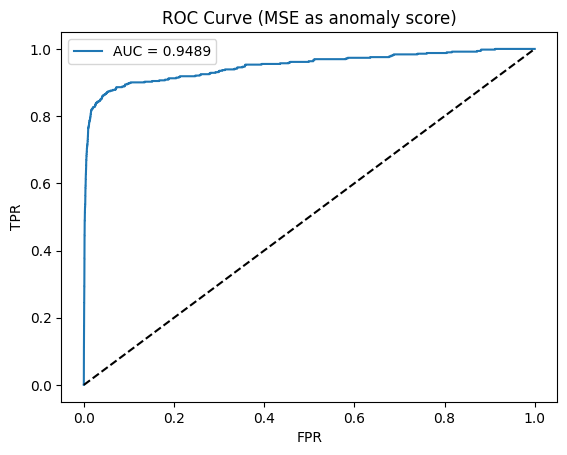

In [74]:
fpr, tpr, _ = roc_curve(y_test, mse)
roc_auc_score_value = auc(fpr, tpr) # Renamed variable to avoid conflict

plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score_value:.4f}') # Use the new variable name
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve (MSE as anomaly score)')
plt.legend()
plt.show()